In [1]:
import numpy as np
import pandas as pd

from scipy.stats import ttest_ind
from statsmodels.stats.power import ttest_power

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from scipy.sparse.linalg import svds

from surprise import SVD, Dataset, Reader
from surprise import Reader
from surprise.model_selection import cross_validate

from surprise.model_selection import KFold
from surprise import accuracy

In [143]:
df = pd.read_csv("ratings_Electronics.csv", names=["userId", "productId", "rating", "timestamp"])

In [13]:
df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [14]:
df.describe()

,rating,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [15]:
df.describe(include="all")

,userId,productId,rating,timestamp
count,7824482,7824482,7.824482e+06,7.824482e+06
unique,4201696,476002,NaN,NaN
top,A5JLAU2ARJ0BO,B0074BW614,NaN,NaN
freq,520,18244,NaN,NaN
mean,NaN,NaN,4.012337e+00,1.338178e+09
std,NaN,NaN,1.380910e+00,6.900426e+07
min,NaN,NaN,1.000000e+00,9.127296e+08
25%,NaN,NaN,3.000000e+00,1.315354e+09
50%,NaN,NaN,5.000000e+00,1.361059e+09
75%,NaN,NaN,5.000000e+00,1.386115e+09


In [28]:
df_10percent_forModeling = df.sample(frac=0.1, random_state=0)

In [29]:
df_10percent_forModeling.describe(include="all")

,userId,productId,rating,timestamp
count,782448,782448,782448.000000,7.824480e+05
unique,672820,167211,NaN,NaN
top,ADLVFFE4VBT8,B0074BW614,NaN,NaN
freq,59,1823,NaN,NaN
mean,NaN,NaN,4.011931,1.338201e+09
std,NaN,NaN,1.381650,6.893014e+07
min,NaN,NaN,1.000000,9.307008e+08
25%,NaN,NaN,3.000000,1.315354e+09
50%,NaN,NaN,5.000000,1.360973e+09
75%,NaN,NaN,5.000000,1.386115e+09


In [30]:
# Null hypothesis

# from scipy.stats import ttest_ind
# from statsmodels.stats.power import ttest_power

# Define funtion to do hypothesis testing
def nullHypothesisValidator(original, updated, serviceColumn, 
                            replaceWithOriginal_ifNullHypthesisRejected=True, p_val_threshold=0.05):
    print("***Checking Null Hypothesis for: ", serviceColumn)
    t_stat, p_val = ttest_ind(original[serviceColumn], updated[serviceColumn])
    #print("t_stat: ", t_stat)
    print("p_val: ", p_val)
    if replaceWithOriginal_ifNullHypthesisRejected:
        if p_val < p_val_threshold:
            updated[serviceColumn] = original[serviceColumn]
            print("Reintroduced column with original values for feature ***", serviceColumn, "'***")
    return

# Read file into a different dataframe. It will be used for referencing in the hypothesis testing.
# data_reference = pd.read_csv("vehicle.csv")
# data_reference = replaceEmptyWithMean_forNumericColumns(data_reference)

In [31]:
nullHypothesisValidator(df, df_10percent_forModeling, "rating")
nullHypothesisValidator(df, df_10percent_forModeling, "timestamp")

***Checking Null Hypothesis for:  rating
p_val:  0.8040350174807097
***Checking Null Hypothesis for:  timestamp
p_val:  0.7793474886998062


In [32]:
# Keeping the below line commented to avoid rerunning the save to csv file line

# # Save the training (10% records) to a seperate file
# df_10percent_forModeling.to_csv("df_10percent_forModeling.csv")

# Continue with the 10% as the main data set

In [33]:
df = df_10percent_forModeling

## STEP 1

Read and explore the given dataset. ( Rename column/add headers, plot histograms,
find data characteristics)

In [35]:
# Rename already done

Text(0.5, 0.98, '')

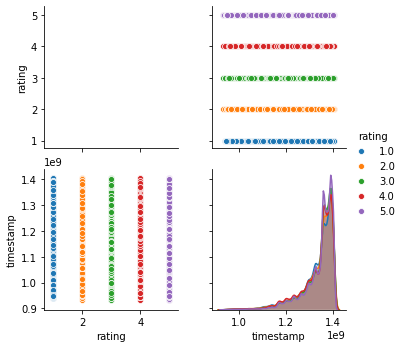

In [42]:
# Check the overall pairplot. Identify which features may have clusters.
# Pairplot of features with suspected clusters
g = sns.pairplot(df, vars=["rating", "timestamp"], 
                 diag_kind="kde", hue="rating")

g.fig.suptitle("", fontsize=40)

Inferences from the pair plot are:
- Ratings are reasonably evenly distributed along the timestamp

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 782448 entries, 3089708 to 4540135
Data columns (total 4 columns):
userId       782448 non-null object
productId    782448 non-null object
rating       782448 non-null float64
timestamp    782448 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 29.8+ MB


# STEP 2
Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the
users only who has given 50 or more number of ratings )

In [2]:
min_ratings = 50

In [2]:
# Keep users who have given more than 50 ratings

# df = pd.read_csv("df_10percent_forModeling.csv")
# df.drop("Unnamed: 0", axis=1, inplace=True)

df = pd.read_csv("ratings_Electronics.csv", names=["userId", "productId", "rating", "timestamp"])

# min_ratings = 50

temp = pd.DataFrame(df.userId.value_counts())
temp.columns = ["frequency"]      # Rename column to frequency
temp["userId"] = temp.index   # Create userId column with value from index, which correspond to the userId


# Filter ratings by comparing with above dataframe
print("Total number of ratings is ", df.shape[0])
# df = pd.merge(df, temp[temp.frequency>=min_ratings], how="inner", on="userId").iloc[:, :-1]   # Exclude the frequency column
df = pd.merge(df, temp[temp.frequency>=min_ratings], how="inner", on="userId").iloc[:, :]
print("Number of ratings with userId occuring more than ", min_ratings, " is ", df.shape[0])
df.head()

Total number of ratings is  7824482
Number of ratings with userId occuring more than  50  is  125871


,userId,productId,rating,timestamp,frequency
0,A3BY5KCNQZXV5U,0594451647,5.0,1390176000,50
1,A3BY5KCNQZXV5U,B00000JD4V,4.0,1118016000,50
2,A3BY5KCNQZXV5U,B000063574,5.0,1016668800,50
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0,1258761600,50
4,A3BY5KCNQZXV5U,B0007Y794O,5.0,1369872000,50


#### NOTE:
- Finding userId with more than 50 ratings in the 10% data was resulting in very few rocords.
- Therefore, finding userId with more than 50 ratings in 100% data. It resulted in 125871 records.
- Will proceed further analysis on this data set.
- Saving it to file for further use.

In [3]:
# Keeping the below line commented to avoid rerunning the save to csv file line

fileName = "userId_withMoreThan" + str(min_ratings) + "Ratings_from100PercentData.csv"

# df.to_csv(fileName, index=False)

In [4]:
df = pd.read_csv(fileName)

In [7]:
df.head()

,userId,productId,rating,timestamp,frequency
0,A3BY5KCNQZXV5U,0594451647,5.0,1390176000,50
1,A3BY5KCNQZXV5U,B00000JD4V,4.0,1118016000,50
2,A3BY5KCNQZXV5U,B000063574,5.0,1016668800,50
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0,1258761600,50
4,A3BY5KCNQZXV5U,B0007Y794O,5.0,1369872000,50


In [8]:
len(df.userId.unique())

1540

In [5]:
# Find users with constant ratings (say always 5)

temp = df['rating'].groupby(df['userId']).unique().apply(pd.Series)   # Dataframe with index on UserId
temp["count_rating"] = temp.apply(lambda x: x.count(), axis=1)   # Count number of columns with values other than NaN
# temp["userId"] = temp.index
temp.reset_index(inplace=True)
temp.head(100)
temp_onlyOneRating = temp[temp.count_rating == 1]
temp_onlyOneRating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 446 to 963
Data columns (total 7 columns):
userId          6 non-null object
0               6 non-null float64
1               0 non-null float64
2               0 non-null float64
3               0 non-null float64
4               0 non-null float64
count_rating    6 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 384.0+ bytes


In [69]:
print("Number of users with same rating each time: ", len(temp_onlyOneRating.userId.unique()))
temp_onlyOneRating.head(10)

Number of users with same rating each time:  6


,userId,0,1,2,3,4,count_rating
446,A23WPWLYT3P1CZ,5.0,NaN,NaN,NaN,NaN,1
543,A2DKQQIZ793AV5,5.0,NaN,NaN,NaN,NaN,1
596,A2J4XMWKR8PPD0,5.0,NaN,NaN,NaN,NaN,1
675,A2PB325LKXYDOL,5.0,NaN,NaN,NaN,NaN,1
731,A2TN0U8173HM7A,5.0,NaN,NaN,NaN,NaN,1
963,A3DL29NLZ7SXXG,5.0,NaN,NaN,NaN,NaN,1


#### There are some users giving constant ratings

Removing these user ratings

In [6]:
# Filter ratings by comparing with above dataframe
print("Total number of ratings is ", df.shape[0])
df = pd.merge(df, temp[temp.count_rating>1], how="inner", on="userId").iloc[:, :-7]
print("Number of ratings after removing userId with constant ratings is: ", df.shape[0])
df.head()

Total number of ratings is  125871
Number of ratings after removing userId with constant ratings is:  125499


,userId,productId,rating,timestamp
0,A3BY5KCNQZXV5U,0594451647,5.0,1390176000
1,A3BY5KCNQZXV5U,B00000JD4V,4.0,1118016000
2,A3BY5KCNQZXV5U,B000063574,5.0,1016668800
3,A3BY5KCNQZXV5U,B0000CDJP8,5.0,1258761600
4,A3BY5KCNQZXV5U,B0007Y794O,5.0,1369872000


In [7]:
len(df.userId.unique())

1534

# STEP 3
Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [8]:
df.drop("timestamp", axis=1, inplace=True)

trainSet, testSet = train_test_split(df, test_size=0.30, random_state=0)

In [9]:
print(trainSet.shape)
print(testSet.shape)

(87849, 3)
(37650, 3)


# STEP 4
Build Popularity Recommender model.

In [10]:
# df_popularity_recommender = x_train
# df_popularity_recommender["rating"] = y_train

# Average rating for the prodictId
ratings_mean_count = pd.DataFrame(trainSet.groupby('productId')['rating'].mean())

# Number of ratings for the product
ratings_mean_count['rating_counts'] = pd.DataFrame(trainSet.groupby('productId')['rating'].count())

# Sort ratings by decreasing order of average-rating. If same average then sort by number-of-ratings in descending order.
ratings_mean_count = ratings_mean_count.sort_values(["rating", "rating_counts"], ascending=False)
ratings_mean_count.head()

,rating,rating_counts
productId,,
B00IX2VGFA,5.0,19
B00A35WYBA,5.0,15
B001TH7GUA,5.0,14
B007BXD66E,5.0,14
B00HG1L334,5.0,14


# STEP 5
Build Collaborative Filtering model.

In [ ]:
# from surprise import SVD, Dataset, Reader
# from surprise import Reader
# from surprise.model_selection import cross_validate

# # The used file in SVD, as per assumption by Reader, must follow structure: [userId, itemId, rating]
# reader = Reader(rating_scale=(1, 5))
# data = Dataset.load_from_df(df, reader)

# trainset = data.build_full_trainset()
# trainset

# # What does trainset.ur do?
#     # It creates a dictionary structure
#     # In the dictionary structure, userId is the key
#     # For each userId-index, the value is a array of all mappings between itemId and ratings.
#     # Note that userId and itemId are represented by their index, instead of actual id.
#     # This way of representing data is called: ???
# trainset.ur


# algo = SVD(n_factors=50, n_epochs=1)
# algo.fit(trainset)

# # Than predict ratings for all pairs (u, i) that are NOT in the training set.
# testset = trainset.build_anti_testset()
# testset

# # Below line results in "memory error"
# predictions = algo.test(testset)
# predictions

In [99]:
# # Format matrix to one row per user and one column per product, with 0 where not rated
# r_df = trainSet.pivot(index="userId", columns="productId", values="rating").fillna(0)
# r_df.head()

# # Calculate mean of each row. Consider only entries which have value more than 0.
# r_matrix = r_df.as_matrix()
# user_rating_sum = np.sum(r_matrix, axis=1)

# user_rating_count = np.count_nonzero(r_matrix, axis=1)

# user_rating_mean = user_rating_sum/user_rating_count

# print(user_rating_mean.shape)
# print(user_rating_mean.reshape(-1, 1).shape)

# # De-mean the data (normalize by each users mean) and convert it from a dataframe to a numpy array
# r_matrix = r_df.as_matrix()
# #user_rating_mean = np.mean(r_matrix, axis=1)   # Mean of each row (average rating given by a user)
# r_demeaned = r_matrix - user_rating_mean.reshape(-1, 1)     # Delete mean from each value to get bias
# r_demeaned

# #from scipy.sparse.linalg import svds

# # Use latent-factor value 50 for approximation. It is the dimension of the sigma matrix.
# U, sigma, Vt = svds(r_demeaned, k = 50)
# # Convert sigma into a diagonal matrix
# sigma = np.diag(sigma)
# sigma

# # We now have everything we need to make rating predictions for every user.
# # We can do it all at once by doing matrix multiplication between U, Σ, and Vt.
# # The multiplication will give back the rank k=50 approximation of R.
# # We also need to add the mean rating by each user back to get the predicted n-star (10 in this case) ratings.

# # Get all user ratings by multiplication of U, sigma and Vt
# allusers_ratings_predications = np.dot(np.dot(U, sigma), Vt) + user_rating_mean.reshape(-1, 1)
# pred_df = pd.DataFrame(allusers_ratings_predications, columns=r_df.columns, index=r_df.index)     # Convert to Dataframe
# pred_df.head()

In [41]:
"""
Solution using the cross_validate approach in Surprise library
"""

# from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9822  0.9858  0.9937  0.9815  0.9810  0.9848  0.0048  
MAE (testset)     0.7269  0.7289  0.7332  0.7282  0.7271  0.7289  0.0023  
Fit time          16.83   15.83   15.91   16.76   18.40   16.75   0.92    
Test time         0.49    0.46    0.40    0.45    0.41    0.44    0.03    


{'test_rmse': array([0.98217941, 0.98575431, 0.9937467 , 0.9815351 , 0.98099856]),
 'test_mae': array([0.72689434, 0.72891942, 0.73323618, 0.72816331, 0.72712358]),
 'fit_time': (16.82659649848938,
  15.830039024353027,
  15.91414213180542,
  16.760195016860962,
  18.39634943008423),
 'test_time': (0.4857451915740967,
  0.4577805995941162,
  0.40293288230895996,
  0.4507863521575928,
  0.4118993282318115)}

In [97]:
"""
Approach using explicit calls to the fit and test of the model
"""

reader = Reader(rating_scale=(1, 5))
data_train = Dataset.load_from_df(trainSet, reader).build_full_trainset()
data_test = [tuple(x) for x in testSet.values]     # prediction is done on a tuple array/list

algo = SVD()

algo.fit(data_train)
predictions = algo.test(data_test)

accuracy.rmse(predictions)

<class 'list'>
RMSE: 0.9882


0.9882178137935227

In [105]:
predictions[0:10]

[Prediction(uid='A2NJQF2UI60VGT', iid='B0039XQQXA', r_ui=4.0, est=4.566069825652414, details={'was_impossible': False}),
 Prediction(uid='A8P6GIIQ6YQV8', iid='B008XVAVAW', r_ui=5.0, est=4.152326723886657, details={'was_impossible': False}),
 Prediction(uid='A2RG1B0K8YBJ4A', iid='B005DJPILE', r_ui=4.0, est=4.318038061249324, details={'was_impossible': False}),
 Prediction(uid='A1ROUMJOGO4QMB', iid='B001KC08A4', r_ui=4.0, est=3.4399320497193004, details={'was_impossible': False}),
 Prediction(uid='A2XJMQ2COPGWJH', iid='B004VRJ3E2', r_ui=4.0, est=3.8517768604135454, details={'was_impossible': False}),
 Prediction(uid='A324X7RVDAV3FT', iid='B000ZNRBK4', r_ui=4.0, est=4.578169787059273, details={'was_impossible': False}),
 Prediction(uid='A3CW0ZLUO5X2B1', iid='B002JCSCYS', r_ui=3.0, est=4.395731246776892, details={'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C', iid='B0002A9U7M', r_ui=5.0, est=4.3371396273916405, details={'was_impossible': False}),
 Prediction(uid='ARBKYIVNYWK3C'

In [11]:
"""
Approach using the KFold
"""

# from surprise.model_selection import KFold
# from surprise import accuracy

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(trainSet, reader)

# define a cross-validation iterator
k = 10
kf = KFold(n_splits=k, random_state=0)

algo_collab = SVD(n_factors=50, n_epochs=10)

acc_sum = 0

for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo_collab.fit(trainset)
    predictions = algo_collab.test(testset)

    # Compute and print Root Mean Squared Error
    acc_sum = acc_sum + accuracy.rmse(predictions, verbose=True)

print("Average RMSE for training set: ", acc_sum/k)

RMSE: 1.0043
RMSE: 0.9783
RMSE: 0.9921
RMSE: 0.9713
RMSE: 0.9873
RMSE: 0.9840
RMSE: 0.9777
RMSE: 0.9860
RMSE: 0.9935
RMSE: 0.9991
Average RMSE for training set:  0.9873496150022516


##### https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/

##### https://surprise.readthedocs.io/en/stable/getting_started.html

# STEP 6
Evaluate both the models. ( Once the model is trained on the training data, it can be
used to compute the error (like RMSE) on predictions made on the test data.) You can
also use a different method to evaluate the models.

In [13]:
"""
Evaluate popularity based model againse the testSet
"""
ratings_mean_count.head()

# This model will alwasy recommend the same productId

,rating,rating_counts
productId,,
B00IX2VGFA,5.0,19
B00A35WYBA,5.0,15
B001TH7GUA,5.0,14
B007BXD66E,5.0,14
B00HG1L334,5.0,14


In [14]:
"""
Evaluate SVD model (collaborative filtering model) againse the testSet
"""
# Predict on testSet
print("\n\n***Do prediction on testSet")
data_test = [tuple(x) for x in testSet.values]     # prediction is done on a tuple array/list
predictions_collab = algo_collab.test(data_test)
accuracy.rmse(predictions_collab, verbose=True)



***Do prediction on testSet
RMSE: 0.9905


0.9905160785029877

# STEP 7
Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to
each user based on his/her habits, we will recommend 5 new products.

In [16]:
k = 5

In [17]:
"""POPULARITY BASED RECOMMENDATION"""
ratings_mean_count.head(k)

# This model will alwasy recommend the same productId

,rating,rating_counts
productId,,
B00IX2VGFA,5.0,19
B00A35WYBA,5.0,15
B001TH7GUA,5.0,14
B007BXD66E,5.0,14
B00HG1L334,5.0,14


In [18]:
"""COLLABORATIVE BASED RECOMMENDATION"""

# # Convert the predicted_collab tuple to Dataframe
# predictedSet = pd.DataFrame(predictions_collab, columns=["userId", "productId", "rating", "predictedRating", "detail"])

# predictedSet.head()

# predictedSet.drop("detail", axis=1, inplace=True)
# predictedSet.head()

# predictedSet[predictedSet.rating == 0].head()

'COLLABORATIVE BASED RECOMMENDATION'

In [18]:
"""Find all unpredicted combinations"""

reader = Reader(rating_scale=(1, 5))
data_train_all = Dataset.load_from_df(df, reader).build_full_trainset()     # Create Dataset of all given ratings
unratedEntries = data_train_all.build_anti_testset()     # Create tuples containing all unrated entries

In [19]:
print(type(unratedEntries))
print(len(unratedEntries))

<class 'list'>
73535647


In [34]:
n = len(unratedEntries)
mini_batch_size = 5000000

mini_batches = [unratedEntries[i:i+mini_batch_size] for i in range(0, n, mini_batch_size)]

print("Number of mini_batches", len(mini_batches))

# predictions_df = pd.DataFrame(columns=["userId", "productId", "rating", "predictedRating"])
predictions_df = pd.DataFrame(columns=["userId", "productId", "rating", "predictedRating"])
iteration = 0

for mini_batch in mini_batches:
    print("Predict for iteration ", iteration)
    tempPredTupil = algo_collab.test(mini_batch)
    tempPredDataFrame = pd.DataFrame(tempPredTupil, columns=["userId", "productId", "rating", "predictedRating", "detail"])
    tempPredDataFrame.drop("detail", axis=1, inplace=True)
    #predictions_df.append(tempPredDataFrame, ignore_index=True)
    predictions_df = pd.concat([predictions_df, tempPredDataFrame], axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)
    iteration = iteration + 1
    print(predictions_df.shape)

Number of mini_batches 15
Predict for iteration  0
(5000000, 4)
Predict for iteration  1
(10000000, 4)
Predict for iteration  2
(15000000, 4)
Predict for iteration  3
(20000000, 4)
Predict for iteration  4
(25000000, 4)
Predict for iteration  5
(30000000, 4)
Predict for iteration  6
(35000000, 4)
Predict for iteration  7
(40000000, 4)
Predict for iteration  8
(45000000, 4)
Predict for iteration  9
(50000000, 4)
Predict for iteration  10
(55000000, 4)
Predict for iteration  11
(60000000, 4)
Predict for iteration  12
(65000000, 4)
Predict for iteration  13
(70000000, 4)
Predict for iteration  14
(73535647, 4)


In [37]:
# predictions_df.to_csv("predictions_df_step7.csv", index=False)

In [38]:
predictions_df.head()

,userId,productId,rating,predictedRating
0,A3BY5KCNQZXV5U,0594481813,4.259149,4.220029
1,A3BY5KCNQZXV5U,B00005105L,4.259149,4.220029
2,A3BY5KCNQZXV5U,B000068O1M,4.259149,4.220029
3,A3BY5KCNQZXV5U,B000068O34,4.259149,4.372876
4,A3BY5KCNQZXV5U,B000068O4J,4.259149,4.293830


In [42]:
print(len(df.userId.unique()))
print(len(df.productId.unique()))

1534
48019


In [67]:
top5Collab = pd.DataFrame(columns=["userId", "1st", "2nd", "3rd", "4th", "5th"])

# Suggest for first 20 userId only (becuase of time constraint. Need to submit assignment in next 6 minutes)

userNoPredicted = 20
userCounter = 0

# Loop on all users
for userId in df.userId.unique():
    # Find unrated products for the user
    ratingsForThisUserId = predictions_df[predictions_df.userId==userId]
    ratingsForThisUserId.sort_values("predictedRating", ascending=False, inplace=True)   # Sort
    ratingsForThisUserId = ratingsForThisUserId.head()     # Keep only 5
    ratingsForThisUserId.reset_index(inplace=True, drop=True)     # Reset the index
    
    # Create dictionary with suggested values
    suggestions = {
        'userId' : userId, 
        "1st": ratingsForThisUserId.iloc[0].productId,
        "2nd": ratingsForThisUserId.iloc[1].productId,
        "3rd": ratingsForThisUserId.iloc[2].productId,
        "4th": ratingsForThisUserId.iloc[3].productId,
        "5th": ratingsForThisUserId.iloc[4].productId
                  }
    
    # Save the dictionary to the dataframe
    top5Collab = top5Collab.append(suggestions, ignore_index=True)
    
    userCounter = userCounter + 1
    if userCounter >= userNoPredicted:
        break

In [68]:
top5Collab

,userId,1st,2nd,3rd,4th,5th
0,A3BY5KCNQZXV5U,B0052SCU8U,B000N99BBC,B0019EHU8G,B001TH7GUU,B008EQZ25K
1,AT09WGFUM934H,B00BOHNYU6,B003ES5ZUU,B001TH7GUU,B0052SCU8U,B000VX6XL6
2,A32HSNCNPRUMTR,B0052SCU8U,B002WE6D44,B000N99BBC,B0019EHU8G,B008EQZ25K
3,A17HMM1M7T9PJ1,B003ES5ZUU,B00BQ4F9ZA,B000QUUFRW,B001TH7T2U,B004Q3R9AQ
4,A3CLWR1UUZT6TG,B001UI2FPE,B0019EHU8G,B006W8U2MU,B00017LSPI,B0052SCU8U
5,A3TAS1AG6FMBQW,B000CRFOMK,B009USAJCC,B006W8U2MU,B000AP05BO,B00E3W15P0
6,A2Y4H3PXB07WQI,B00BQ4F9ZA,B001TH7GUU,B000N99BBC,B00IVFDZBC,B0019EHU8G
7,A25RTRAPQAJBDJ,B0052SCU8U,B000N99BBC,B0019EHU8G,B00BQ4F9ZA,B002V8C3W2
8,A3LDPF5FMB782Z,B00017LSPI,B0052SCU8U,B0019EHU8G,B003ES5ZUU,B007WTAJTO
9,A1A5KUIIIHFF4U,B0052SCU8U,B002WE6D44,B0019EHU8G,B003ES5ZUU,B002V88HFE


# STEP 8
Summarise your insights.

- The popularity based recommendation will result same output for each userId
- The collobaration based recommendation is better if user has a history